---
# combine aggregated spills files
---

In [1]:
import os
import pathlib
import yaml
import numpy
import pandas
import xarray
import h5netcdf
from datetime import datetime
from glob import glob
import time
from matplotlib import pyplot as plt, cm, colors, ticker
import matplotlib as mpl
mpl.rc('font', size=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')


### Aggregation functions

In [2]:
def beaching_aggregate(beaching_files,file_idx):
    b = {}
    beach_aggregate = {}
    print([*file_idx])
    # loop through oil types to aggregate
    for oil in [*file_idx]:
        # load first file
        print(beaching_files[file_idx[oil][0]])
        beach_aggregate[oil] = xarray.open_dataset(beaching_files[file_idx[oil][0]])
        nspills=beach_aggregate[oil].attrs['N_spills']
        files=beach_aggregate[oil].attrs['Filenames'].tolist()
        for idx in range(1,len(file_idx[oil])):
            # load next Xarray
            print(beaching_files[file_idx[oil][idx]])
            b[idx] = xarray.open_dataset(beaching_files[file_idx[oil][idx]])
            # aggregate (n-1) Xarray with (n) Xarray, with special handling
            # for Min. Beaching time 
            BeachTimeMin = beach_aggregate[oil]['BeachTime_Min']
            beach_aggregate[oil] = beach_aggregate[oil]+b[idx]
            # Address special case: Min beaching time
            # Keep time value if it's less than "n" case and real; otherwise, 
            # choose time from nth case, even if NaT.
            beach_aggregate[oil]['BeachTime_Min']=xarray.where(
                numpy.logical_and(
                    BeachTimeMin<b[idx]['BeachTime_Min'],
                    numpy.isreal(BeachTimeMin)),
                    BeachTimeMin.values,
                    b[idx]['BeachTime_Min'].values
            )
            files+=b[idx].attrs['Filenames'].tolist()
            nspills+=b[idx].attrs['N_spills']
            b[idx].close()
        # update spill count and filename list to reflect full aggregation
        beach_aggregate[oil].attrs['N_spills']=nspills
        beach_aggregate[oil].attrs['Filenames']=files
        
    return beach_aggregate
        
def surface_aggregate(surface_files,file_idx):
    sfc = {}
    sfc_aggregate = {}
    # loop through oil types to aggregate
    for oil in [*file_idx]:
        # load first file
        print(surface_files[file_idx[oil][0]])
        sfc_aggregate[oil] = xarray.open_dataset(surface_files[file_idx[oil][0]])
        nspills=sfc_aggregate[oil].attrs['N_spills']
        files=sfc_aggregate[oil].attrs['Filenames'].tolist()
        for idx in range(1,len(file_idx[oil])):
            # load next Xarray
            print(surface_files[file_idx[oil][idx]])
            sfc[idx] = xarray.open_dataset(surface_files[file_idx[oil][idx]])
            # aggregate (n-1) Xarray with (n) Xarray
            sfc_aggregate[oil] = sfc_aggregate[oil]+sfc[idx]
            # concatenate files
            files+=sfc[idx].attrs['Filenames'].tolist()
            # total up number of runs in aggregation
            nspills+=sfc[idx].attrs['N_spills']
            sfc[idx].close()
        # update spill count and filename list to reflect full aggregation
        sfc_aggregate[oil].attrs['N_spills']=nspills
        sfc_aggregate[oil].attrs['Filenames']=files      
    return sfc_aggregate        

### load runlist used to create aggregated files 

In [3]:
yaml_file=pathlib.Path(
     '/home/rmueller/projects/def-allen/rmueller/MIDOSS/Visualization',
     'MOHID_results_locations_07102021_15:52:22.yaml')
with yaml_file.open("rt") as f:
    run_paths = yaml.safe_load(f) 

In [4]:
run_paths['akns'][0]

'/scratch/dlatorne/MIDOSS/runs/monte-carlo/near-BP_13th-100_2021-09-25T163257/results/near-BP_13th-100-61/Lagrangian_akns-61_near-BP_13th-100-61.nc'

### create list of aggregated files by oil type

In [5]:
output_netcdf_dir=pathlib.Path('/scratch/rmueller/MIDOSS/Results/test_17') 
beaching_files = sorted(glob(os.path.join(output_netcdf_dir,"beaching_*")))
surface_files = sorted(glob(os.path.join(output_netcdf_dir,"surface_*")))

In [6]:
beaching_files

['/scratch/rmueller/MIDOSS/Results/test_17/beaching_bunker_0-50.nc',
 '/scratch/rmueller/MIDOSS/Results/test_17/beaching_bunker_0-500.nc',
 '/scratch/rmueller/MIDOSS/Results/test_17/beaching_bunker_50-100.nc',
 '/scratch/rmueller/MIDOSS/Results/test_17/beaching_diesel_0-50.nc',
 '/scratch/rmueller/MIDOSS/Results/test_17/beaching_diesel_50-100.nc']

In [7]:
# b1 = xarray.open_dataset(beaching_files[0], engine='h5netcdf')
# b2 = xarray.open_dataset(beaching_files[1], engine='h5netcdf')
# [*b1]

### Review beaching time calc. 

In [9]:
import cartopy.crs
from cartopy import feature
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

ModuleNotFoundError: No module named 'cartopy'

In [10]:
x1 = xarray.open_dataset(run_paths['akns'][0], engine='h5netcdf')

In [11]:
nanosecond_to_hour = 1e-9/3600
spill_start=x1.time[0]
one_day = numpy.timedelta64(24,'h')
dt_beaching=(x1.Beaching_Time-spill_start)*nanosecond_to_hour
dt_surface=(x1.Oil_Arrival_Time-spill_start)*nanosecond_to_hour
print(f'Max beaching time: {dt_beaching.max().values.item()} hrs')
print(f'Max surface time: {dt_surface.max().values.item()} hrs')

Max beaching time: 79 hrs
Max surface time: 77 hrs


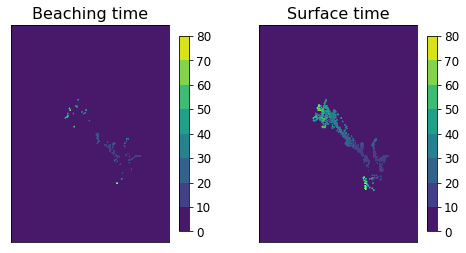

In [12]:
%matplotlib inline    
fig, axs = plt.subplots(1, 2, figsize=(8, 4), 
                        gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
cs0=axs[0].contourf(dt_beaching)
cs1=axs[1].contourf(dt_surface)
axs[0].set_title(f'Beaching time')
axs[1].set_title(f'Surface time')
fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='vertical')
fig.colorbar(cs0, ax=axs[1], shrink=0.9, orientation='vertical')
for ind in numpy.arange(0,2):
    axs[ind].set_xticks([])
    axs[ind].set_xlim(150,350)
    axs[ind].set_yticks([])
    axs[ind].set_ylim(200,450)

In [13]:
# %matplotlib inline    
# fig, axs = plt.subplots(1, 2, figsize=(8, 4), 
#                         gridspec_kw={'wspace': 0.25, 'hspace': 0.1},
#                        subplot_kw={"projection": rotated_crs, "facecolor": "white"})
# for ind in numpy.arange(0,2):
#     axs[ind].add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', facecolor='#8b7765'), zorder=1)
# cs0=axs[0].contourf(dt_beaching)
# cs1=axs[1].contourf(dt_surface)
# axs[0].set_title(f'Beaching time')
# axs[1].set_title(f'Surface time')
# fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='vertical')
# fig.colorbar(cs0, ax=axs[1], shrink=0.9, orientation='vertical')
# for ind in numpy.arange(0,2):
#     axs[ind].set_xticks([])
#     axs[ind].set_xlim(150,350)
#     axs[ind].set_yticks([])
#     axs[ind].set_ylim(200,450)

In [16]:
vol3d=x1.OilWaterColumnOilVol_3D.isel({'grid_z': 39})
test = vol3d.where(vol3d>15,0).loc[dict(
                time=slice(x1.time[0],x1.time[0]+numpy.timedelta64(24,'h'))
                )]

## Plot restults from test run 

In [17]:
geomean_vars = ['SurfaceConcentration_SumSum','SurfaceVolume_MaxSum', 
            'SurfaceVolume_SumSum','SurfaceVolume_SumSum_24h',
            'SurfaceVolume_SumSum_24h_to_72h','SurfaceVolume_SumSum_72h_to_168h',
            'TotalBeachVolume']
mean_vars = ['BeachTime_Sum']

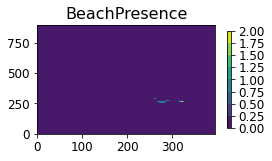

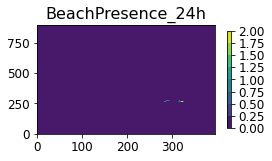

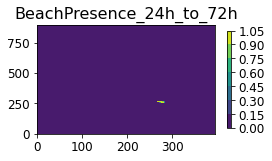

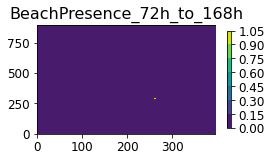

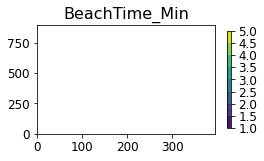

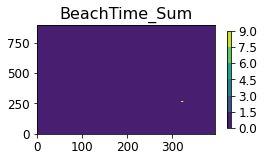

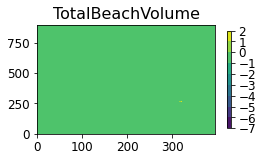

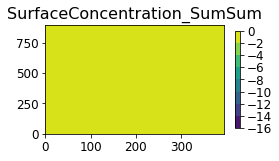

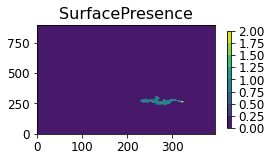

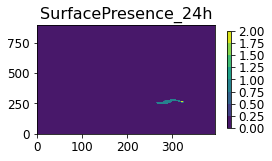

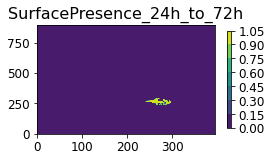

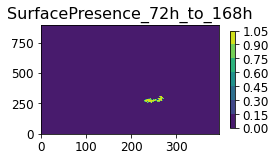

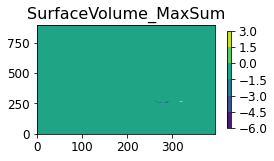

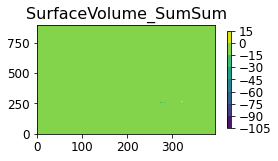

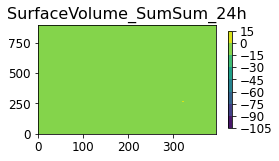

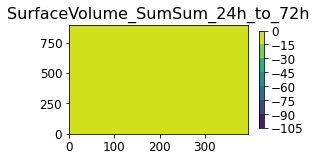

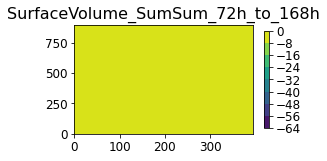

In [18]:
ba = xarray.open_dataset('/scratch/rmueller/MIDOSS/Results/beaching_diesel_0-3.nc', engine='h5netcdf')
sa = xarray.open_dataset('/scratch/rmueller/MIDOSS/Results/surface_diesel_0-3.nc', engine='h5netcdf')
for var in [*ba]:
    fig, axs = plt.subplots(1, 1, figsize=(4, 2), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
    cs0=axs.contourf(ba[var])
    axs.set_title(f'{var}')
    fig.colorbar(cs0, ax=axs, shrink=0.9, orientation='vertical')
for var in [*sa]:
    fig, axs = plt.subplots(1, 1, figsize=(4, 2), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
    cs0=axs.contourf(sa[var])
    axs.set_title(f'{var}')      
    fig.colorbar(cs0, ax=axs, shrink=0.9, orientation='vertical')


# for var in [*ba]:
#     fig, axs = plt.subplots(1, 1, figsize=(4, 2), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
#     if var not in mean_vars:
#         cs0=axs.contourf(ba[var])
#         axs.set_title(f'{var}')
#         if var in geomean_vars:
#             cs0=axs.contourf(
#             numpy.exp(ba[var]/ba.attrs['N_spills'])
#             )
#             axs.set_title('Bunker \nGeometric Mean Volume (m$^3$)')
#     else:
#         cs0=axs.contourf(
#             ba[var]/ba.attrs['N_spills']
#             )
#         axs.set_title('Avg Beaching Time (hours)')
#     fig.colorbar(cs0, ax=axs, shrink=0.9, orientation='vertical')
# for var in [*sa]:
#     fig, axs = plt.subplots(1, 1, figsize=(4, 2), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
#     if var not in geomean_vars:
#         cs0=axs.contourf(sa[var])
#         axs.set_title(f'{var}')
#     else:
#         cs0=axs.contourf(
#             numpy.exp(sa[var]/sa.attrs['N_spills'])
#         )
#         if var == 'SurfaceConcentration_SumSum':
#             axs.set_title('Geometric Mean Conc. (Kg/m$^3$)')
#         else:
#             axs.set_title(f'{var}')
            
#     fig.colorbar(cs0, ax=axs, shrink=0.9, orientation='vertical')
ba.close()
sa.close()

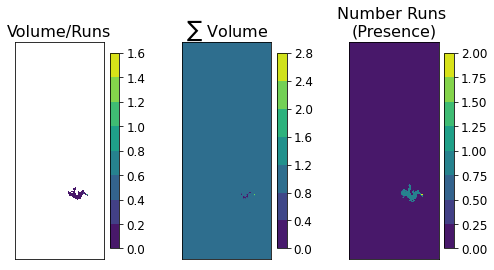

In [19]:
MeanVol = sa['SurfaceVolume_SumSum']/sa['SurfacePresence']
cs={}
fig, axs = plt.subplots(1, 3, figsize=(8, 4), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
cs[0]=axs[0].contourf(numpy.exp(MeanVol))
cs[1]=axs[1].contourf(numpy.exp(sa['SurfaceVolume_SumSum']))
cs[2]=axs[2].contourf(sa['SurfacePresence'])
axs[0].set_title('Volume/Runs')
axs[1].set_title('$\sum$ Volume')
axs[2].set_title('Number Runs \n(Presence)')
for ind in numpy.arange(0,3):
    fig.colorbar(cs[ind], ax=axs[ind], shrink=0.9, orientation='vertical')
    axs[ind].set_xticks([])
    axs[ind].set_yticks([])

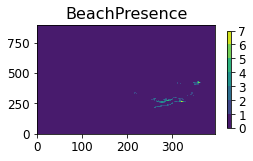

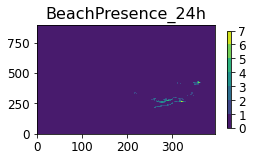

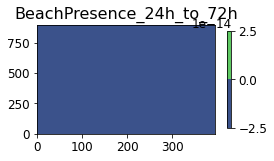

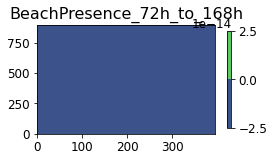

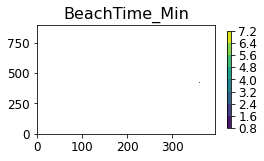

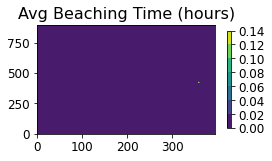

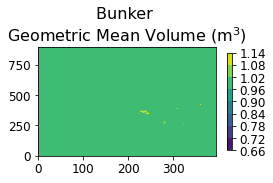

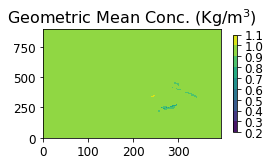

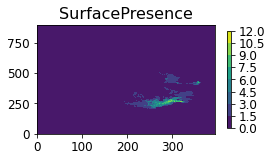

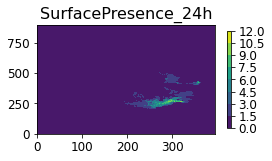

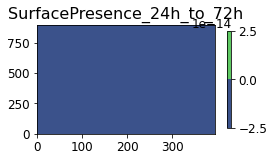

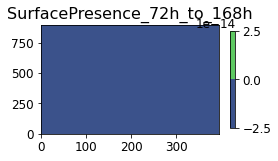

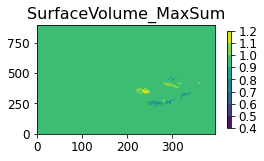

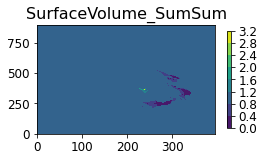

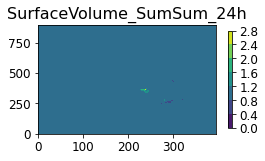

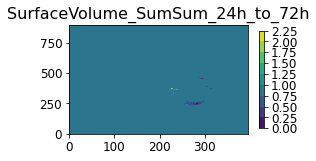

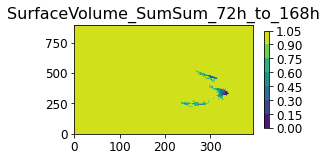

In [20]:
ba = xarray.open_dataset('/scratch/rmueller/MIDOSS/Results/beaching_diesel_0-50.nc', engine='h5netcdf')
sa = xarray.open_dataset('/scratch/rmueller/MIDOSS/Results/surface_diesel_0-50.nc', engine='h5netcdf')

for var in [*ba]:
    fig, axs = plt.subplots(1, 1, figsize=(4, 2), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
    if var not in mean_vars:
        cs0=axs.contourf(ba[var])
        axs.set_title(f'{var}')
        if var in geomean_vars:
            cs0=axs.contourf(
            numpy.exp(ba[var]/ba.attrs['N_spills'])
            )
            axs.set_title('Bunker \nGeometric Mean Volume (m$^3$)')
    else:
        cs0=axs.contourf(
            ba[var]/ba.attrs['N_spills']
            )
        axs.set_title('Avg Beaching Time (hours)')
    fig.colorbar(cs0, ax=axs, shrink=0.9, orientation='vertical')
for var in [*sa]:
    fig, axs = plt.subplots(1, 1, figsize=(4, 2), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
    if var not in geomean_vars:
        cs0=axs.contourf(sa[var])
        axs.set_title(f'{var}')
    else:
        cs0=axs.contourf(
            numpy.exp(sa[var]/sa.attrs['N_spills'])
        )
        if var == 'SurfaceConcentration_SumSum':
            axs.set_title('Geometric Mean Conc. (Kg/m$^3$)')
        else:
            axs.set_title(f'{var}')
            
    fig.colorbar(cs0, ax=axs, shrink=0.9, orientation='vertical')
    

# Aggregate Beaching and Surface files

In [21]:
# Create dictionary with indices of file to aggregate by oil type
# (Identifying indices will eventually be coded in)
beaching_file_idx = {}
beaching_file_idx['bunker']=[0,1]
beaching_file_idx['diesel']=[2,3]

In [22]:
ba = beaching_aggregate(beaching_files,beaching_file_idx)
sa = surface_aggregate(surface_files,beaching_file_idx) #file index same for beaching in this case

['bunker', 'diesel']
/scratch/rmueller/MIDOSS/Results/test_17/beaching_bunker_0-50.nc
/scratch/rmueller/MIDOSS/Results/test_17/beaching_bunker_0-500.nc
/scratch/rmueller/MIDOSS/Results/test_17/beaching_bunker_50-100.nc
/scratch/rmueller/MIDOSS/Results/test_17/beaching_diesel_0-50.nc
/scratch/rmueller/MIDOSS/Results/test_17/surface_bunker_0-50.nc
/scratch/rmueller/MIDOSS/Results/test_17/surface_bunker_0-500.nc
/scratch/rmueller/MIDOSS/Results/test_17/surface_bunker_50-100.nc
/scratch/rmueller/MIDOSS/Results/test_17/surface_diesel_0-50.nc


In [23]:
[*sa['bunker']]

['SurfaceConcentration_SumSum',
 'SurfacePresence',
 'SurfacePresence_24h',
 'SurfacePresence_24h_to_72h',
 'SurfacePresence_72h_to_168h',
 'SurfaceVolume_MaxSum',
 'SurfaceVolume_SumSum',
 'SurfaceVolume_SumSum_24h',
 'SurfaceVolume_SumSum_24h_to_72h',
 'SurfaceVolume_SumSum_72h_to_168h']

In [24]:
[*ba['bunker']]

['BeachPresence',
 'BeachPresence_24h',
 'BeachPresence_24h_to_72h',
 'BeachPresence_72h_to_168h',
 'BeachTime_Min',
 'BeachTime_Sum',
 'TotalBeachVolume']

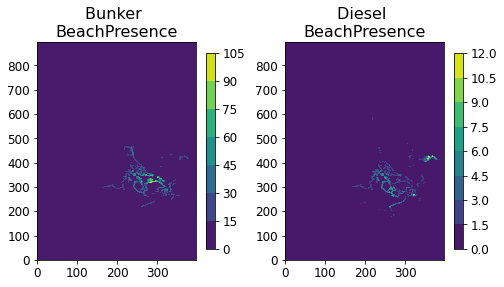

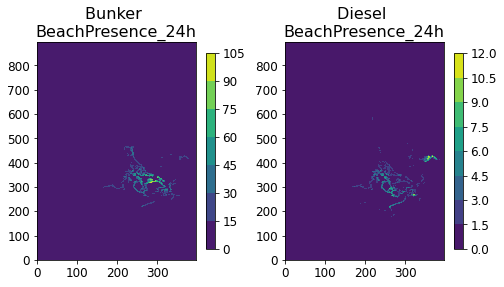

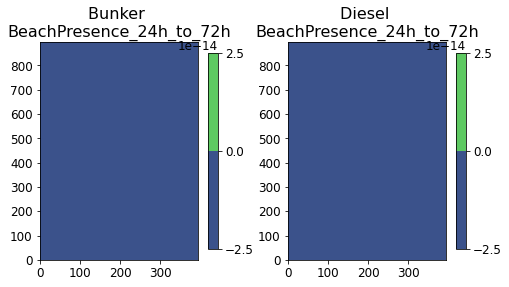

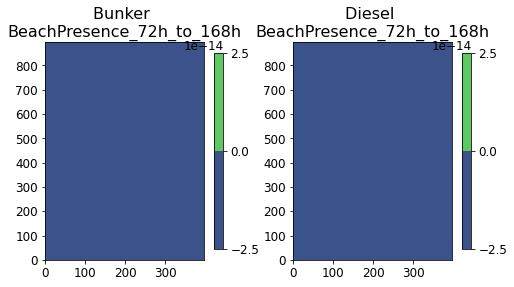

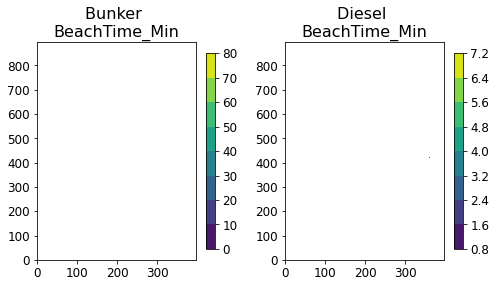

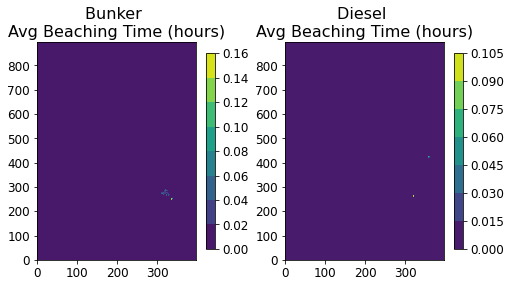

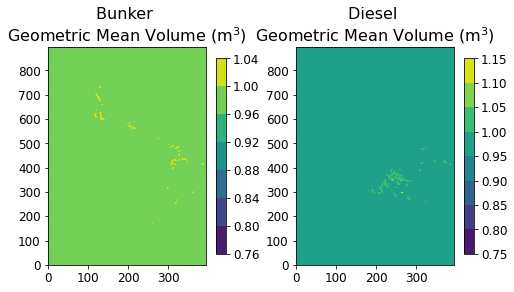

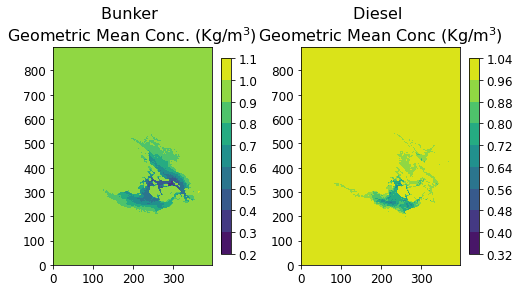

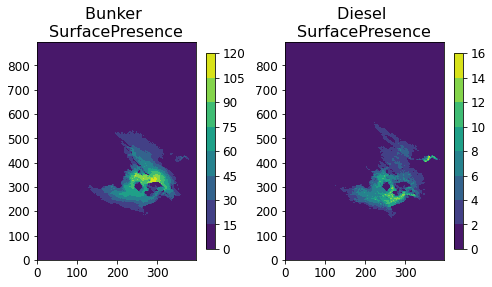

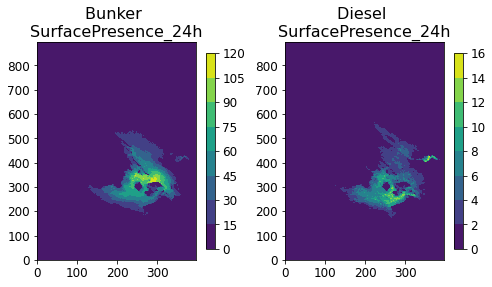

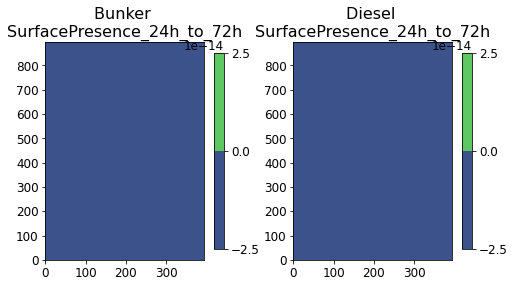

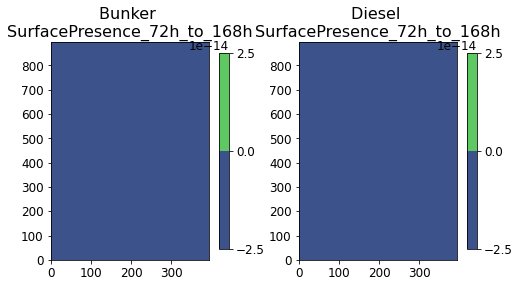

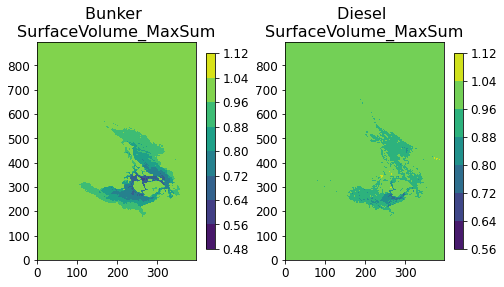

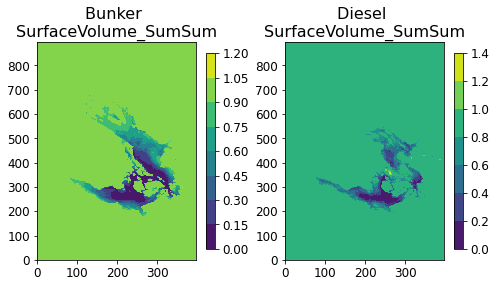

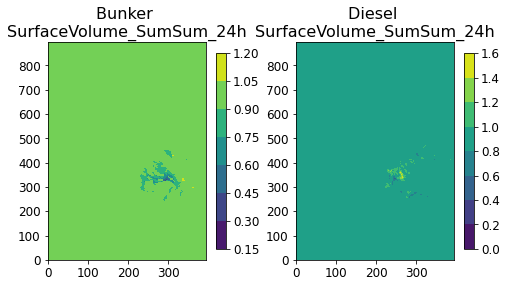

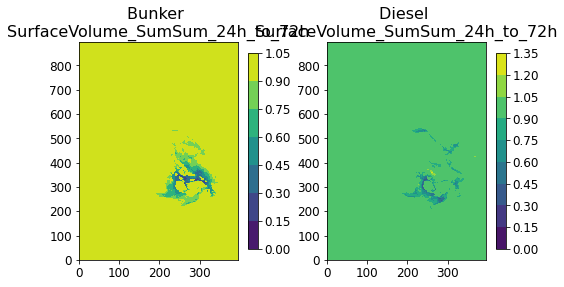

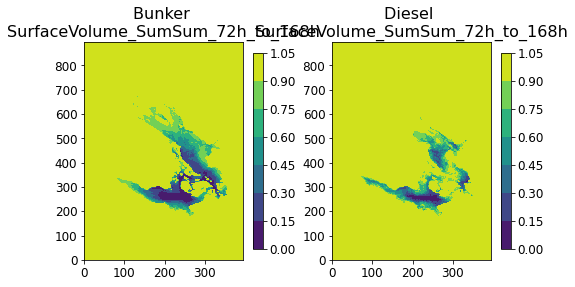

In [25]:
for var in [*ba['bunker']]:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
    if var not in mean_vars:
        cs0=axs[0].contourf(ba['bunker'][var])
        cs1=axs[1].contourf(ba['diesel'][var])
        axs[0].set_title(f'Bunker \n{var}')
        axs[1].set_title(f'Diesel \n{var}')
        if var in geomean_vars:
            cs0=axs[0].contourf(
            numpy.exp(ba['bunker'][var]/ba['bunker'].attrs['N_spills'])
            )
            cs1=axs[1].contourf(
            numpy.exp(ba['diesel'][var]/ba['diesel'].attrs['N_spills'])
            )
            axs[0].set_title('Bunker \nGeometric Mean Volume (m$^3$)')
            axs[1].set_title('Diesel \nGeometric Mean Volume (m$^3$)')
    else:
        cs0=axs[0].contourf(
            ba['bunker'][var]/ba['bunker'].attrs['N_spills']
            )
        cs1=axs[1].contourf(
        ba['diesel'][var]/ba['diesel'].attrs['N_spills']
        )
        axs[0].set_title('Bunker \nAvg Beaching Time (hours)')
        axs[1].set_title('Diesel \nAvg Beaching Time (hours)')
    fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='vertical')
    fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='vertical')
for var in [*sa['bunker']]:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
    if var not in geomean_vars:
        cs0=axs[0].contourf(sa['bunker'][var])
        cs1=axs[1].contourf(sa['diesel'][var])
        axs[0].set_title(f'Bunker \n{var}')
        axs[1].set_title(f'Diesel \n{var}')
    else:
        cs0=axs[0].contourf(
        numpy.exp(sa['bunker'][var]/sa['bunker'].attrs['N_spills'])
        )
        cs1=axs[1].contourf(
        numpy.exp(sa['diesel'][var]/sa['diesel'].attrs['N_spills'])
        )
        if var == 'SurfaceConcentration_SumSum':
            axs[0].set_title('Bunker \nGeometric Mean Conc. (Kg/m$^3$)')
            axs[1].set_title('Diesel \nGeometric Mean Conc (Kg/m$^3$)')
        else:
            axs[0].set_title(f'Bunker \n{var}')
            axs[1].set_title(f'Diesel \n{var}')

    fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='vertical')
    fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='vertical')

# Plot Beaching

In [26]:
vmin = ba['bunker']['TotalBeachVolume'].where(ba['bunker']['TotalBeachVolume']>0).min()
vmax = ba['bunker']['TotalBeachVolume'].where(ba['bunker']['TotalBeachVolume']>0).max()
levels = numpy.linspace(numpy.exp(vmin), 1e7, 5)
levels

array([1.00205270e+00, 2.50000075e+06, 5.00000050e+06, 7.50000025e+06,
       1.00000000e+07])

In [ ]:
ba['bunker'].attrs['N_spills']

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
cs0=axs[0].contourf(ba['bunker']['BeachPresence'])
cs1=axs[1].contourf(ba['bunker']['BeachPresence_24h'])
cs2=axs[2].contourf(
    numpy.exp(ba['bunker']['TotalBeachVolume']/ba['bunker'].attrs['N_spills']),
    #locator=ticker.LogLocator(),
    levels=levels
)
axs[0].set_title('100 Aggregated files\nBeachPresence')
axs[1].set_title('100 Aggregated files\nBeachPresence_24h_to_72h')
axs[2].set_title('100 Aggregated files\nGeometric Mean Volume (m$^3$)')
fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='horizontal')
fig.colorbar(cs2, ax=axs[2], shrink=0.9, orientation='horizontal')

In [ ]:
from matplotlib import pyplot as plt, cm, colors, ticker
fig, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
cs0=axs[0].contourf(ba['bunker']['BeachPresence'])
cs1=axs[1].contourf(ba['bunker']['BeachPresence_24h'])
#cs2=axs[2].contourf(numpy.log(ba['bunker']['TotalBeachVolume'].where(ba['bunker']['TotalBeachVolume']>0)))
cs2=axs[2].contourf(ba['bunker']['TotalBeachVolume'])
axs[0].set_title('100 Aggregated files\nBeachPresence')
axs[1].set_title('100 Aggregated files\nBeachPresence_24h_to_72h')
axs[2].set_title('100 Aggregated files\n$\ln$(TotalBeachVolume)')
fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='horizontal')
fig.colorbar(cs2, ax=axs[2], shrink=0.9, orientation='horizontal')

In [ ]:
print('--------')
print('BEACHING')
print('--------')
for oil in ['bunker','diesel']:
    print('***',oil,'***')
    for variable in [*ba[oil]]:
        variable
        print(variable,': ', numpy.nanmin(ba[oil][variable].values).item(),
              '-', ba[oil][variable].max().values.item())
print('-------')
print('SURFACE')
print('-------')
for oil in ['bunker','diesel']:
    print('***',oil,'***')
    for variable in [*sa[oil]]:
        variable
        print(variable,': ', sa[oil][variable].min().values.item(),
              '-', sa[oil][variable].max().values.item())

# Surface

In [ ]:
surface_files

In [ ]:
for oil in [*beaching_file_idx]:
    print(oil)

In [ ]:
[*sa]

In [ ]:
sfc = {}
sfc[0]=xarray.open_dataset(surface_files[file_idx['bunker'][0]])
sfc[1]=xarray.open_dataset(surface_files[file_idx['bunker'][1]])

In [ ]:
[*sfc[0]]

###  Aggregate n and (n-1) file

In [ ]:
sfc_aggregated = sfc[0] + sfc[1]
#sfc_aggregated = sfc[1]

In [ ]:
for variable in [*sfc_aggregated]:
    variable
    print(variable,': ', numpy.exp(sfc_aggregated[variable].min().values.item()),
          '-', sfc_aggregated[variable].max().values.item())

In [ ]:
limits={}
limits['SurfacePresence']=(0,20)


In [ ]:
for var_idx,variable in enumerate([*sfc[0]]):
    if variable != 'SurfaceDissolution_SumSum':
        fig,axs = plt.subplots(
            1, 3, figsize=(18, 9), 
            subplot_kw={"facecolor": "white"}
        )
        fig.subplots_adjust(hspace=0.5)
        if variable=='SurfacePresence':
            cs0=axs[0].contourf(sfc[0][variable], 
                levels=numpy.linspace(limits[variable][0],limits[variable][1],20))
            cs1=axs[1].contourf(sfc[1][variable], 
                levels=numpy.linspace(limits[variable][0],limits[variable][1],20))
            cs2=axs[2].contourf(numpy.exp(sfc_aggregated[variable]),norm=colors.LogNorm())
        else:
            cs0=axs[0].contourf(sfc[0][variable])
            cs1=axs[1].contourf(sfc[1][variable])
            cs2=axs[2].contourf(sfc_aggregated[variable])
        axs[0].set_ylabel(variable)
        # axs[1].set_title('BeachPresence_24h_to_72h')
        # axs[2].set_title('TotalBeachVolume')
        fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
        fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='horizontal')
        fig.colorbar(cs2, ax=axs[2], shrink=0.9, orientation='horizontal')

## Compare two-ways of aggregating surface presence

In [ ]:
sfcPresence_aggregated = sfc[0]['SurfacePresence'] + sfc[1]['SurfacePresence']
sum(sum(sfc_aggregated[variable] - sfcPresence_aggregated)).values.item()

In [ ]:
variable = 'SurfacePresence'
fig,axs = plt.subplots(
    1, 2, figsize=(9, 9), 
    subplot_kw={"facecolor": "white"}
)
fig.subplots_adjust(hspace=0.5)
cs0=axs[0].contourf(sfcPresence_aggregated, 
        levels=numpy.linspace(limits[variable][0],limits[variable][1],10))
cs1=axs[1].contourf(sfc_aggregated[variable],
        levels=numpy.linspace(limits[variable][0],limits[variable][1],10))

axs[0].set_title('SurfacePresence \n(direct addition)')
axs[1].set_title('SurfacePresence \n(Xarray addition)')
cbar1=fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
cbar2=fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='horizontal')
labels = numpy.arange(limits[variable][0],limits[variable][1],2)
cbar1.set_ticks(labels)
cbar2.set_ticks(labels)
#cbar.ax.set_xticklabels(labels, rotation=45)

## Evaluate surface dissolution, concentration and volume in the top 5 largest spills in these aggregations 

In [ ]:
First100 = {}
for oil in ['diesel','bunker']:
    First100[oil] = run_paths[oil][0:100]

In [ ]:
First100['diesel'][0]

In [ ]:
First100['diesel'][0].split('/')[0:-1]

In [ ]:
First100['diesel'][0].split('_')[-3]

In [ ]:
"/".join(First100['diesel'][0].split("/")[:-1]) 

### Get spill volumes and sort spills to get 5 largest spills by oil type

In [ ]:
big5_spills={}
for oil in ['diesel','bunker']:
    volume = {}
    volume[oil]={}
    volume[oil]['volume']=[]
    for idx,ncfile in enumerate(First100[oil]):
        directory = "/".join(ncfile.split("/")[:-1]) 
        oil_tag = First100[oil][idx].split('_')[-3]
        # Open the Lagrangian file used for spill
        Lagrangian_file = directory+'/Lagrangian_'+oil_tag+'.dat'
        with open(Lagrangian_file, 'r') as f:
            for line in f:
                if 'POINT_VOLUME              :' in line: 
                    # select spill volume quantity after ':'
                    spillvolume = line.split(':')[-1].split('\n')[0]
                    # convert to float for "sort_values" to work properly
                    volume[oil]['volume'].append(float(spillvolume)) 
        big5_spills[oil] = pandas.DataFrame.from_dict(
            volume[oil]).sort_values('volume',ascending=False)[0:5]

In [ ]:
big5_spills['diesel']

### Use indices from big5_spills to open and plot output from the top 5 spills

In [ ]:
big5_spills[oil].index.values

In [ ]:
%%time
TopSpills = pandas.read_csv('/home/rmueller/projects/def-allen/rmueller/MIDOSS/analysis-rachael/notebooks/monte_carlo_dev/TopSpills_df.csv')

# ## Generate "TopSpills_df.csv"
# ## This section takes 10 minutes on 5210 Mb
# vars2plot= ['Dissolution_3D','OilConcentration_3D','OilWaterColumnOilVol_3D']
# oil_type=[]
# spill_index=[]
# spill_volume=[]
# #variable_list = []
# mn={}
# mx={}
# for variable in vars2plot:
#     mn[variable] = []
#     mx[variable] = []

# for oil in ['diesel','bunker']:
#     # loop through indices of the 5 largest spills in the first 100 spill files
#     for idx in big5_spills[oil].index.values:
#         spill_xr=xarray.open_dataset(First100[oil][idx])
#         oil_type.append(oil)
#         spill_index.append(idx)
#         spill_volume.append(big5_spills[oil]['volume'][idx])
#         for variable in vars2plot:
#             print(f'[{oil}-{idx}-{variable}]')     
#             mn[variable].append(spill_xr[variable][:,39,:,:].min().values.item())
#             mx[variable].append(spill_xr[variable][:,39,:,:].max().values.item())
#         spill_xr.close()
# TopSpills = {'oil_type':oil_type, 'spill_volume':spill_volume,
#     'MinSfcDiss':mn['Dissolution_3D'], 'MaxSfcDiss':mx['Dissolution_3D'],
#     'MinSfcConc':mn['OilConcentration_3D'], 'MaxSfcConc':mx['OilConcentration_3D'],
#     'MinSfcVol':mn['OilWaterColumnOilVol_3D'], 'MaxSfcVol':mx['OilWaterColumnOilVol_3D']}
# TopSpills_df = pandas.DataFrame(TopSpills)
# TopSpills_df.to_csv('TopSpills_df.csv')

In [ ]:
TopSpills

In [ ]:
Conc2Vol = TopSpills['MaxSfcVol']/TopSpills['MaxSfcConc']

In [ ]:
TopSpills[TopSpills['oil_type']=='diesel'].plot.scatter(x='MaxSfcVol',y='MaxSfcConc',s=60, c='purple')

In [ ]:
TopSpills[TopSpills['oil_type']=='bunker'].plot.scatter(x='MaxSfcVol',y='MaxSfcConc', 
                                                        s=60, c='green')

## Get top 50 spills

In [ ]:
big50_spills={}
for oil in ['diesel','bunker']:
    volume = {}
    volume[oil]={}
    volume[oil]['volume']=[]
    for idx,ncfile in enumerate(First100[oil]):
        directory = "/".join(ncfile.split("/")[:-1]) 
        oil_tag = First100[oil][idx].split('_')[-3]
        # Open the Lagrangian file used for spill
        Lagrangian_file = directory+'/Lagrangian_'+oil_tag+'.dat'
        with open(Lagrangian_file, 'r') as f:
            for line in f:
                if 'POINT_VOLUME              :' in line: 
                    # select spill volume quantity after ':'
                    spillvolume = line.split(':')[-1].split('\n')[0]
                    # convert to float for "sort_values" to work properly
                    volume[oil]['volume'].append(float(spillvolume)) 
        big50_spills[oil] = pandas.DataFrame.from_dict(
            volume[oil]).sort_values('volume',ascending=False)[0:50]

In [ ]:
# %%time

# spills_dict = big50_spills.copy
# # if os.path.exists('/home/rmueller/projects/def-allen/rmueller/MIDOSS/analysis-rachael/notebooks/monte_carlo_dev/TopSpills50_df.csv'): 
# #     TopSpills = pandas.read_csv('/home/rmueller/projects/def-allen/rmueller/MIDOSS/analysis-rachael/notebooks/monte_carlo_dev/TopSpills50_df.csv')
# # else:
# ## Generate "TopSpills_df.csv"
# ## This section takes 10 minutes on 5210 Mb
# vars2plot= ['OilConcentration_3D','OilWaterColumnOilVol_3D']
# oil_type=[]
# spill_index=[]
# spill_volume=[]
# #variable_list = []
# mn={}
# mx={}
# mean={}
# for variable in vars2plot:
#     mn[variable] = []
#     mx[variable] = []
#     mean[variable] = []

# for oil in ['diesel','bunker']:
#     # loop through indices of the largest spills in the first 100 spill files
#     for idx in big50_spills[oil].index.values:
#         spill_xr=xarray.open_dataset(First100[oil][idx])
#         oil_type.append(oil)
#         spill_index.append(idx)
#         spill_volume.append(big50_spills[oil]['volume'][idx])
#         for variable in vars2plot:
#             print(f'[{oil}-{idx}-{variable}]')     
#             mn[variable].append(spill_xr[variable][:,39,:,:].min().values.item())
#             mx[variable].append(spill_xr[variable][:,39,:,:].max().values.item())
#             mean[variable].append(spill_xr[variable][:,39,:,:].mean().values.item())
#         spill_xr.close()
# TopSpills = {'oil_type':oil_type, 'spill_volume':spill_volume,
#     'MeanSfcConc':mean['OilConcentration_3D'], 'MinSfcConc':mn['OilConcentration_3D'], 
#     'MaxSfcConc':mx['OilConcentration_3D'], 'MeanSfcVol':mean['OilWaterColumnOilVol_3D'],
#     'MinSfcVol':mn['OilWaterColumnOilVol_3D'], 'MaxSfcVol':mx['OilWaterColumnOilVol_3D']}
# TopSpills_df = pandas.DataFrame(TopSpills)
# TopSpills_df.to_csv('TopSpills50_df.csv')

## plot up Concentration vs. Volume for 50 diesel and 50 bunker spills

In [ ]:
TopSpills = pandas.read_csv('/home/rmueller/projects/def-allen/rmueller/MIDOSS/analysis-rachael/notebooks/monte_carlo_dev/TopSpills50_df.csv')

In [ ]:
TopSpills[:5]

In [ ]:
TopSpills['OilFlag'] = TopSpills['oil_type']
TopSpills.loc[TopSpills['oil_type'] == 'bunker', 'OilFlag'] = 2
TopSpills.loc[TopSpills['oil_type'] == 'diesel', 'OilFlag'] = 1

In [ ]:
TopSpills[TopSpills['oil_type']=='diesel'].plot.scatter(x='MaxSfcVol',y='MaxSfcConc',
                                                        s=60, c='purple')
TopSpills[TopSpills['oil_type']=='bunker'].plot.scatter(x='MaxSfcVol',y='MaxSfcConc', 
                                                        s=60, c='green')
TopSpills[TopSpills['oil_type']=='diesel'].plot.scatter(x='MeanSfcVol',y='MeanSfcConc',
                                                        s=60, c='purple')
TopSpills[TopSpills['oil_type']=='bunker'].plot.scatter(x='MeanSfcVol',y='MeanSfcConc', 
                                                        s=60, c='green')
TopSpills['Vol2Conc'] = TopSpills['MaxSfcVol']/TopSpills['MaxSfcConc']   
ax_ratio = TopSpills.plot.scatter(x='OilFlag',y='Vol2Conc', s=60, c='blue')
ax_ratio.set_xticks((0,1,2,3))
ax_ratio.set_xticklabels(['','diesel','bunker',''])
ax_ratio.set_title('Ratio of Maximum Volume to Maximum Concentration')
TopSpills['Vol2Conc_mean'] = TopSpills['MeanSfcVol']/TopSpills['MeanSfcConc']
ax_ratio = TopSpills.plot.scatter(x='OilFlag',y='Vol2Conc_mean', 
                                                        s=60, c='blue')
ax_ratio.set_xticks((0,1,2,3))
ax_ratio.set_xticklabels(['','diesel','bunker',''])
ax_ratio.set_title('Ratio of Mean Volume to Mean Concentration')

